In [1822]:
import torch
from torch import Tensor
from torch.distributions import Exponential
import numpy as np
import torch
from sklearn.datasets import make_circles
import pandas as pd
import matplotlib.pyplot as plt
import random

In [1823]:
n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03, # a little bit of noise to the dots
                    random_state=42) # keep random state so we get the same values

circles = pd.DataFrame({"X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})
#make dataset in dataframe - taken from learnpytorch.io

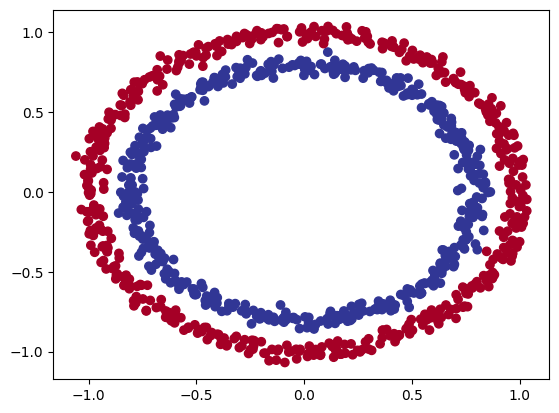

In [1824]:
plt.scatter(x=X[:, 0], 
            y=X[:, 1], 
            c=y, 
            cmap=plt.cm.RdYlBu);

#dataset visualized - need to classify red vs blue circle

In [1825]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [1826]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [1827]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [1828]:
def sample_poisson_relaxed(lmbd, num_samples=1000, temperature = 0.01):
    sampler = torch.empty(num_samples)
    z = Exponential(lmbd).rsample(sampler.size())
    t = torch.cumsum(z, 0)
    relaxed_indicator = torch.sigmoid((1.0 - t) / temperature)
    N = relaxed_indicator.sum()

#     print(lmbd)
#     print(N)
    return N.item()

def poisson_activation(x):
    for i in range(x.size(dim=0)):
            for j in range(x.size(dim=1)):
                y = x[i][j].item()
            
                # print(y) 
                if y < 0:
                     x[i][j] = -sample_poisson_relaxed(-y)
                if y > 0:
                     x[i][j] = sample_poisson_relaxed(y)
                if y ==0:
                     x[i][j] = 0
    return(x)

def poisson_squared(x):
    for i in range(x.size(dim=0)):
          for j in range(x.size(dim=1)):
               y = x[i][j].item()
               
            
                # print(y) 
               if y ==0:
                    x[i][j] = 0
               else:
                    x[i][j] = sample_poisson_relaxed(y**2)
               
    return(x)

In [1829]:

# def sample_poisson_relaxed(lmbd, num_samples=1000, temperature = 0.01):
#     sampler = torch.empty(num_samples)
#     z = Exponential(lmbd).rsample(sampler.size())
#     t = torch.cumsum(z, 0)
#     relaxed_indicator = torch.sigmoid((1.0 - t) / temperature)
#     N = relaxed_indicator.sum()
#     return N

import PhotonActivation

from torch.distributions.multivariate_normal import MultivariateNormal
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
class CircleModelV0(nn.Module):
    def __init__(self, scale, hiddenCount):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling X and y input and output shapes
        self.layer_1 = nn.Linear(in_features=2, out_features=hiddenCount) # takes in 2 features (X), produces 5 features
        self.layer_2 = nn.Linear(in_features=hiddenCount, out_features=1) # takes in 5 features, produces 1 feature (y)
        # self.layer_3 = nn.Linear(in_features=10, out_features=1) # takes in 5 features, produces 1 feature (y)
        self.act = PhotonActivation.PhotonActivation(sampler='bernoulli')
        self.scale = scale

        

    
    # 3. Define a forward method containing the forward pass computation
    def forward(self, x):

        x = x*self.scale
        # for i in range(x.size(dim=0)):
        #     for j in range(x.size(dim=1)):
        #         y = x[i][j]
        #         # print(y) 
        #         x[i][j] = y*2
        # print(x)
        layer1 = self.layer_1(x)
        # layer2 = self.layer_2(torch.relu((layer1)))
        # layer2 = self.layer_2(torch.relu(poisson_activation(layer1)))
        layer2 = self.layer_2(self.act(layer1))
        return layer2

def makeModel(scale, hiddenCount):
    return CircleModelV0(scale, hiddenCount).to(device)

In [1830]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [1831]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


In [1832]:
# Plot decision boundaries for training and test sets
def plot(scale, neurons):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Train (scale = {a}) (neurons = {b})".format(a = scale, b = neurons))
    plot_decision_boundary(model_0, X_train, y_train)
    plt.subplot(1, 2, 2)
    plt.title("Test")
    plot_decision_boundary(model_0, X_test, y_test)

1.0
CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=1, bias=True)
  (act): PhotonActivation(
    (act): PhotonCountingP()
  )
)
Epoch: 0 | Loss: 2690.93945, Accuracy: 45.62% | Test loss: 535.41730, Test acc: 52.50%
Epoch: 100 | Loss: 2675.12158, Accuracy: 50.00% | Test loss: 529.20636, Test acc: 49.00%
Epoch: 200 | Loss: 2671.69727, Accuracy: 54.62% | Test loss: 530.77783, Test acc: 52.00%
Epoch: 300 | Loss: 2654.18018, Accuracy: 21.12% | Test loss: 527.85651, Test acc: 25.00%
Epoch: 400 | Loss: 2620.66992, Accuracy: 0.62% | Test loss: 521.78925, Test acc: 3.50%
Epoch: 500 | Loss: 2622.87158, Accuracy: 0.00% | Test loss: 518.03241, Test acc: 0.00%
Epoch: 600 | Loss: 2612.95874, Accuracy: 0.00% | Test loss: 517.76117, Test acc: 0.00%
Epoch: 700 | Loss: 2605.56372, Accuracy: 0.00% | Test loss: 515.62927, Test acc: 0.00%
Epoch: 800 | Loss: 2604.08691, Accuracy: 0.12% | Test loss: 513.32465, Test acc: 0.00%
Epoc

/var/folders/gc/hlp0fxfj0jl64cgsm01vkmkm0000gn/T/ipykernel_53060/2354060042.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(12, 6))


Epoch: 100 | Loss: 22709.49414, Accuracy: 3.00% | Test loss: 2656.06885, Test acc: 0.00%
Epoch: 200 | Loss: 13908.47168, Accuracy: 0.00% | Test loss: 5273.88086, Test acc: 0.00%
Epoch: 300 | Loss: 22892.92578, Accuracy: 0.00% | Test loss: 1936.97168, Test acc: 0.00%
Epoch: 400 | Loss: 17616.49414, Accuracy: 0.00% | Test loss: 3731.34473, Test acc: 1.00%
Epoch: 500 | Loss: 16162.87988, Accuracy: 0.00% | Test loss: 3427.90796, Test acc: 1.50%
Epoch: 600 | Loss: 20064.32227, Accuracy: 3.25% | Test loss: 2987.60840, Test acc: 0.00%
Epoch: 700 | Loss: 20965.09180, Accuracy: 1.25% | Test loss: 3248.10156, Test acc: 8.50%
Epoch: 800 | Loss: 18137.53906, Accuracy: 0.38% | Test loss: 4599.66455, Test acc: 0.00%
Epoch: 900 | Loss: 25929.01172, Accuracy: 0.00% | Test loss: 4559.31396, Test acc: 3.50%
10.0
CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=30, bias=True)
  (layer_2): Linear(in_features=30, out_features=1, bias=True)
  (act): PhotonActivation(
    (act): PhotonCountingP

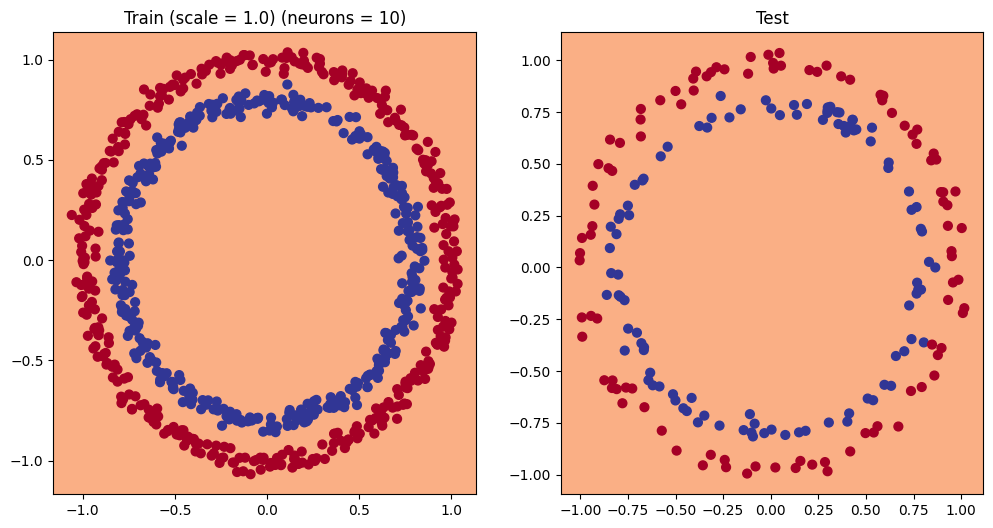

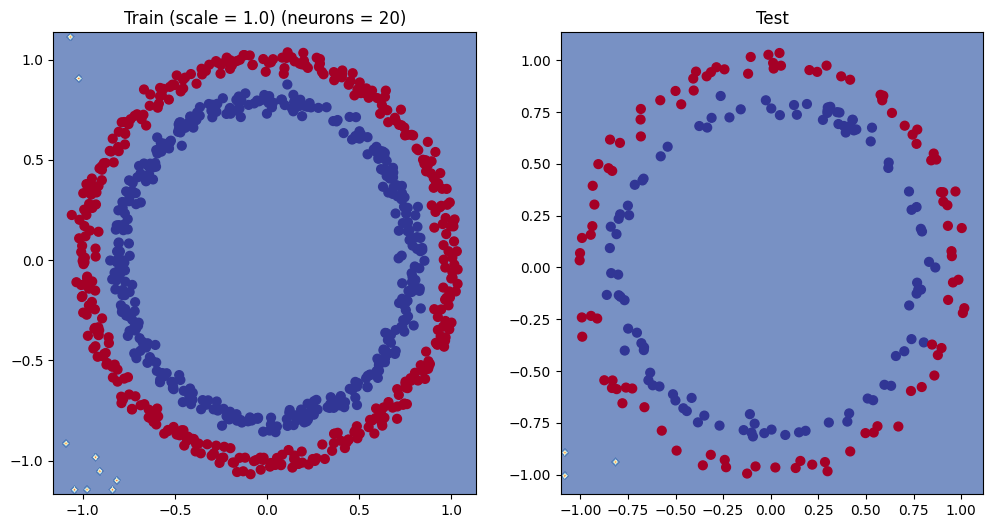

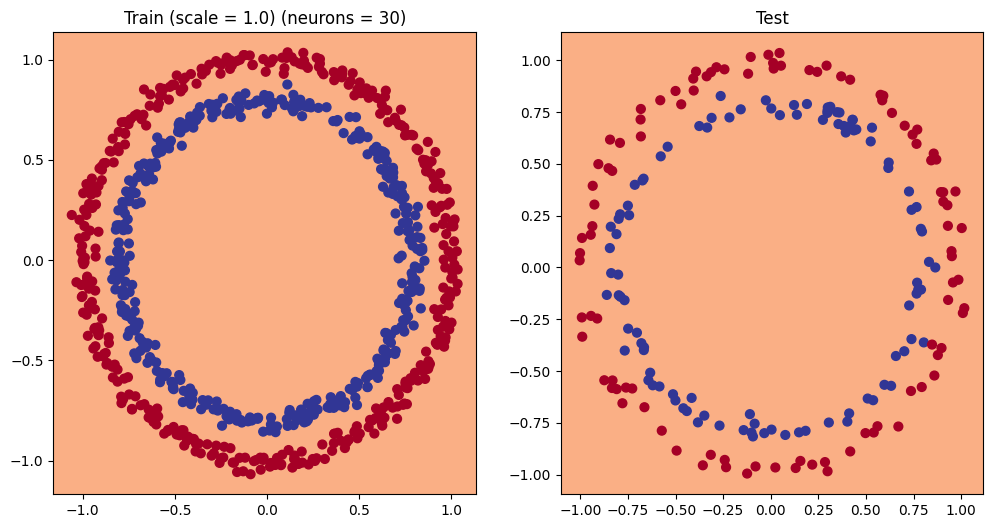

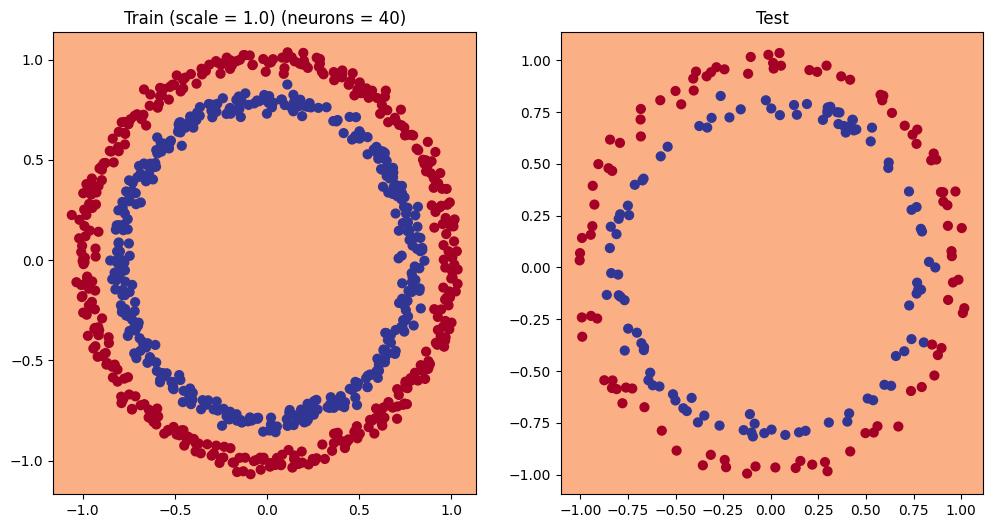

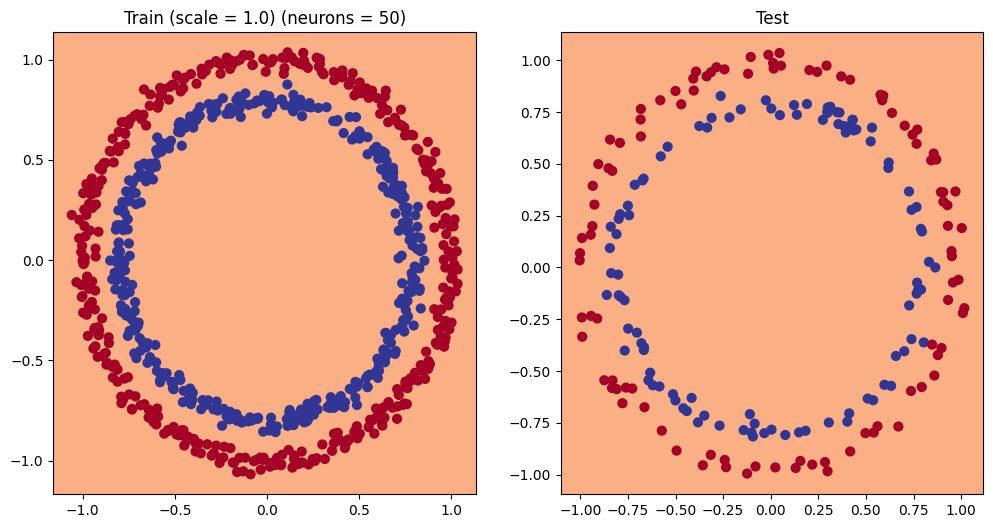

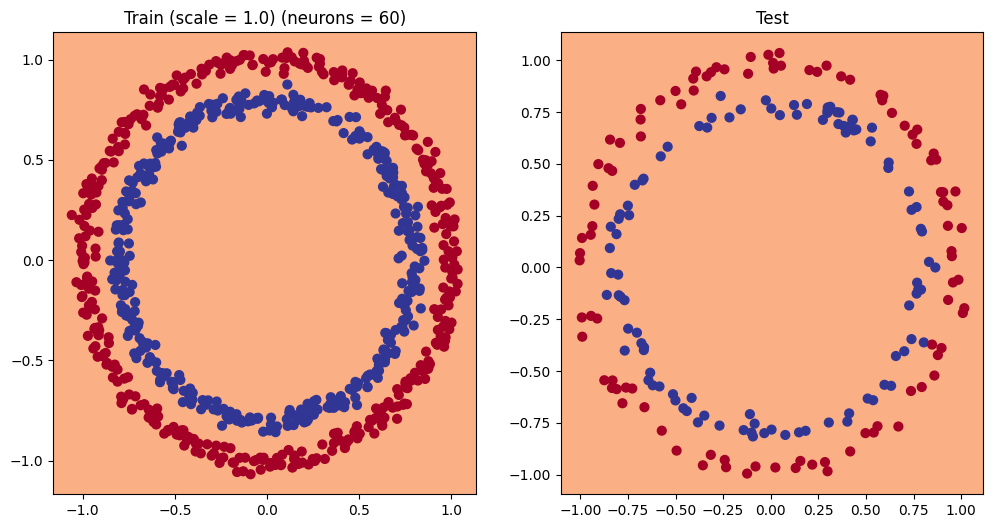

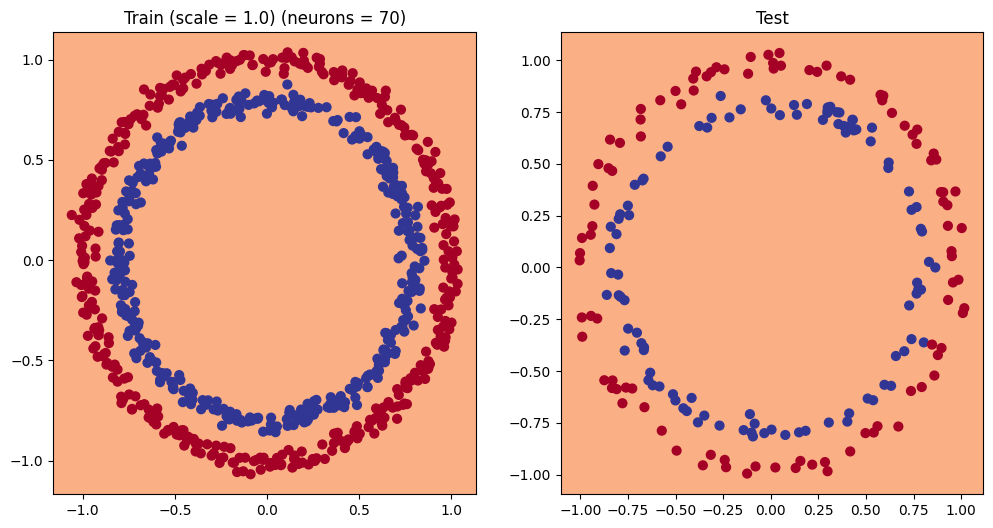

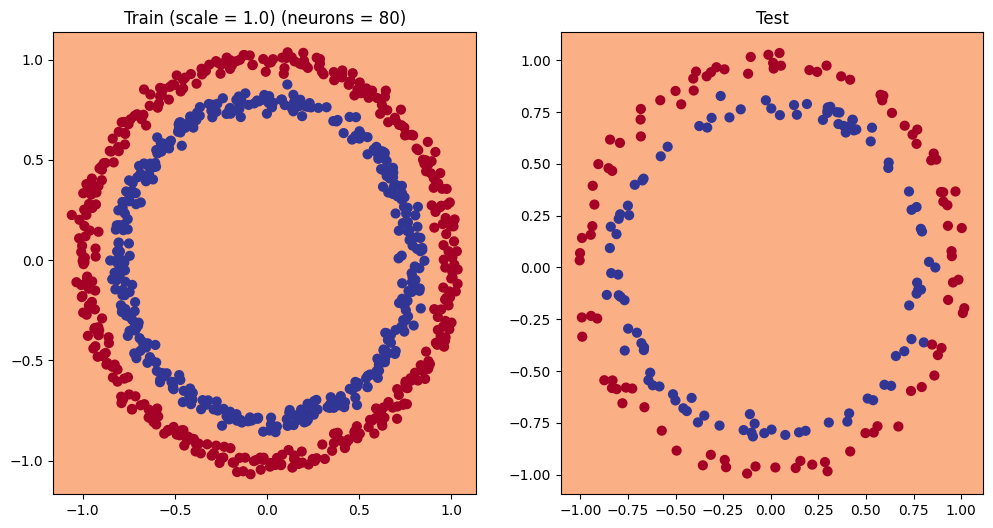

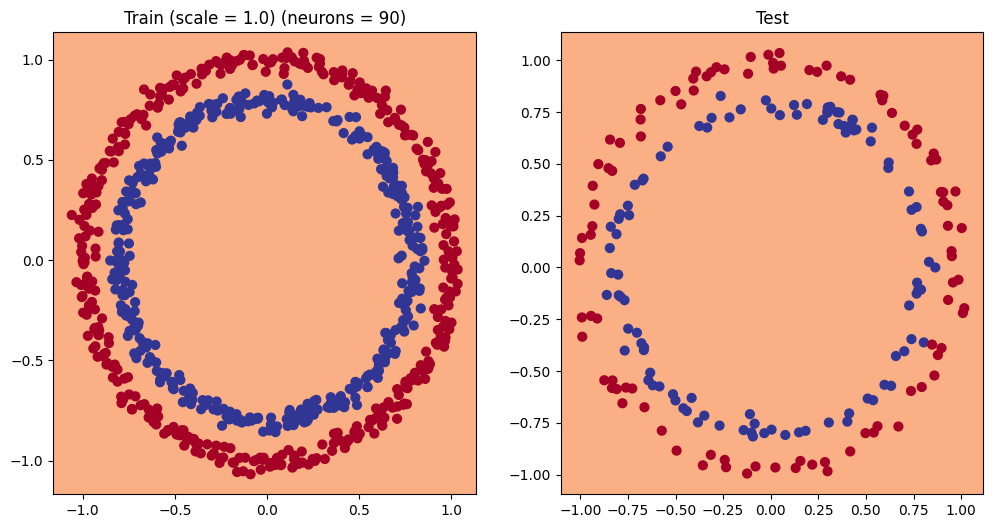

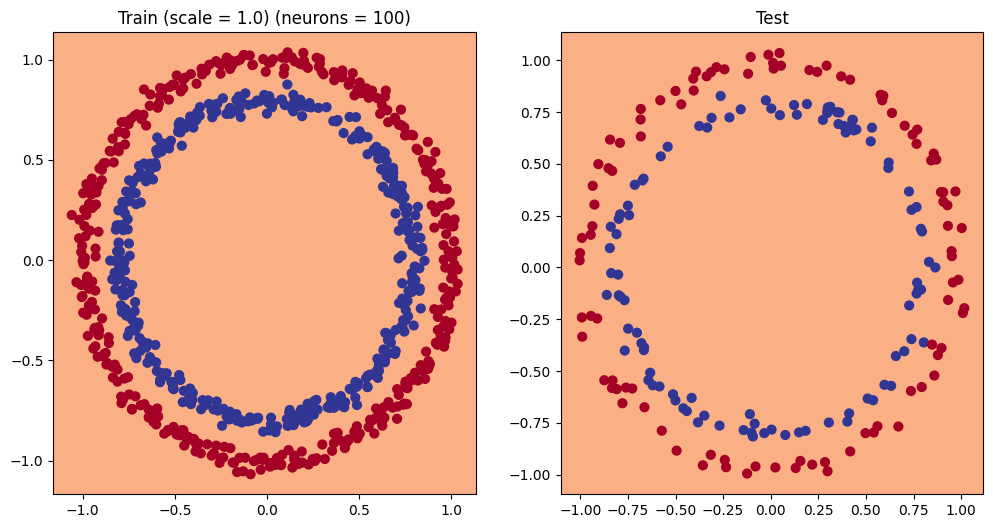

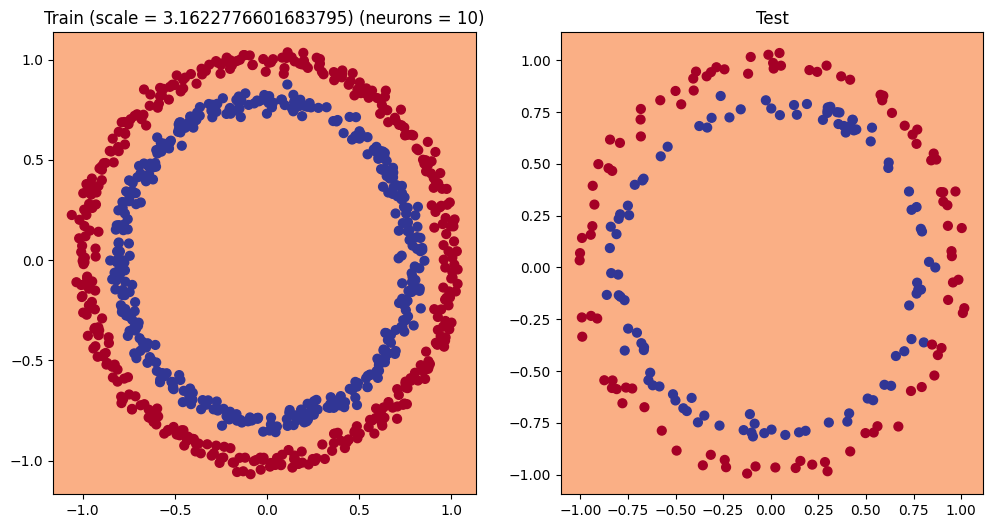

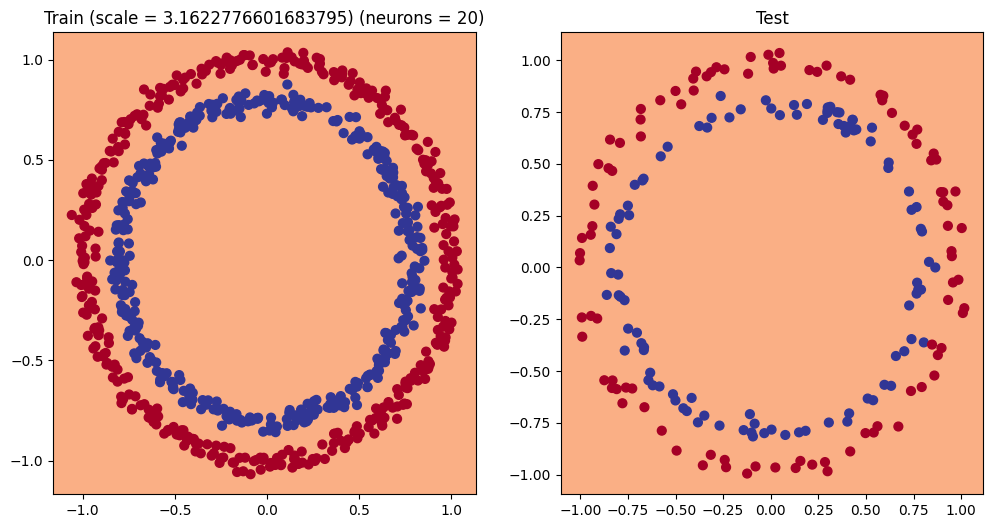

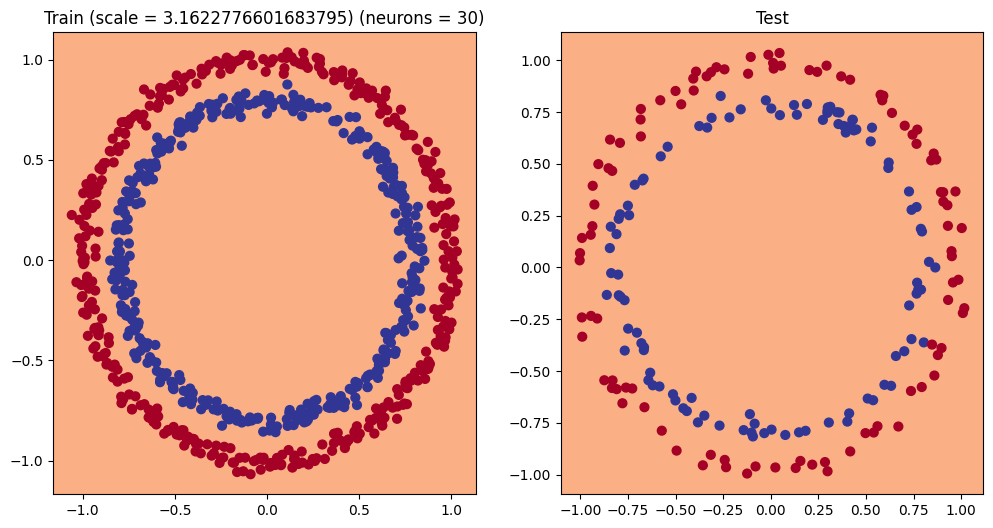

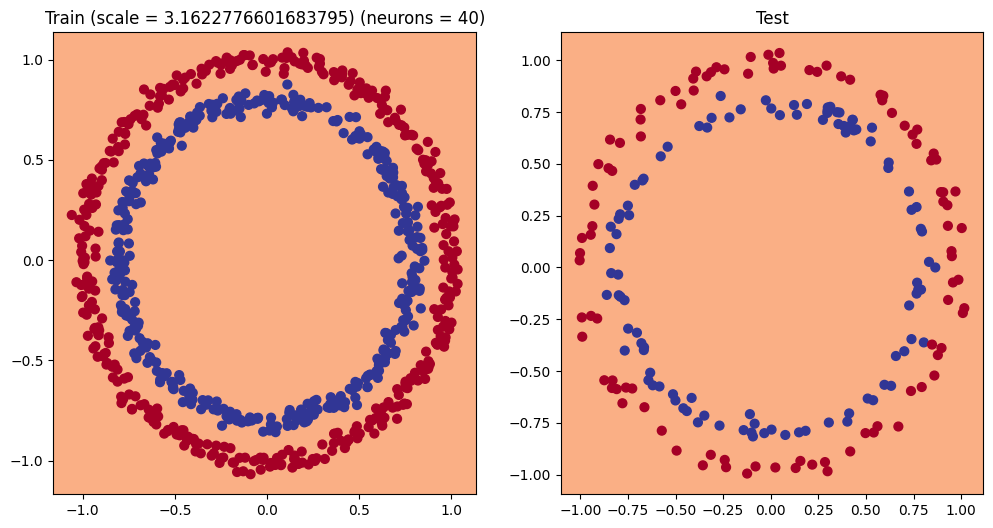

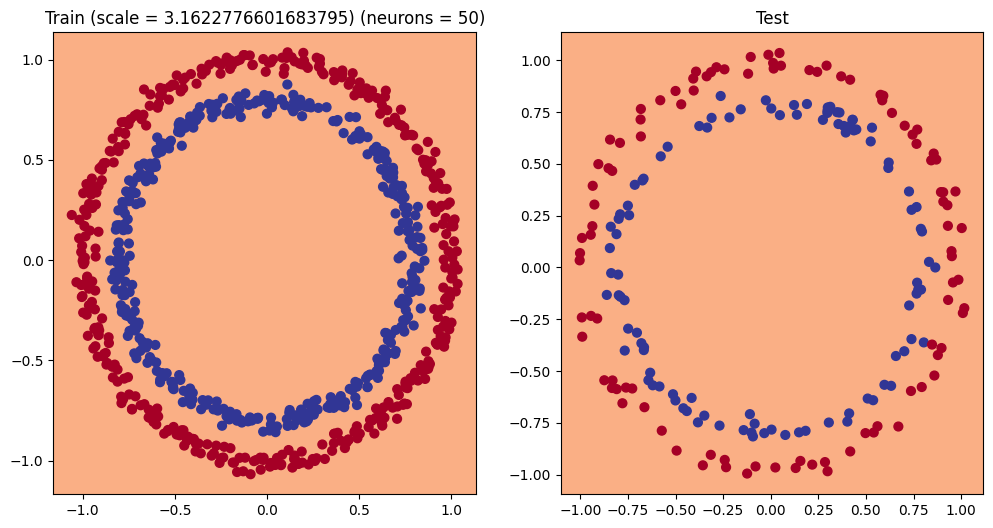

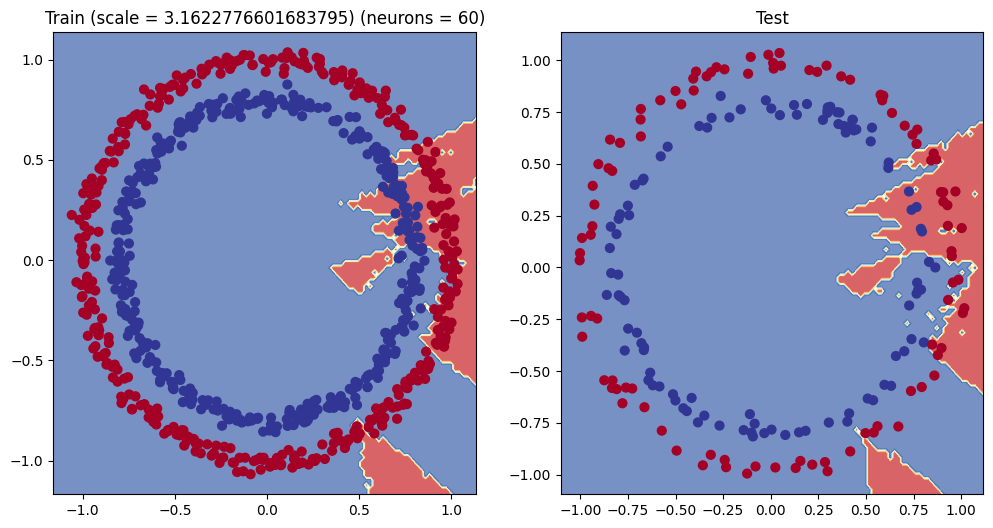

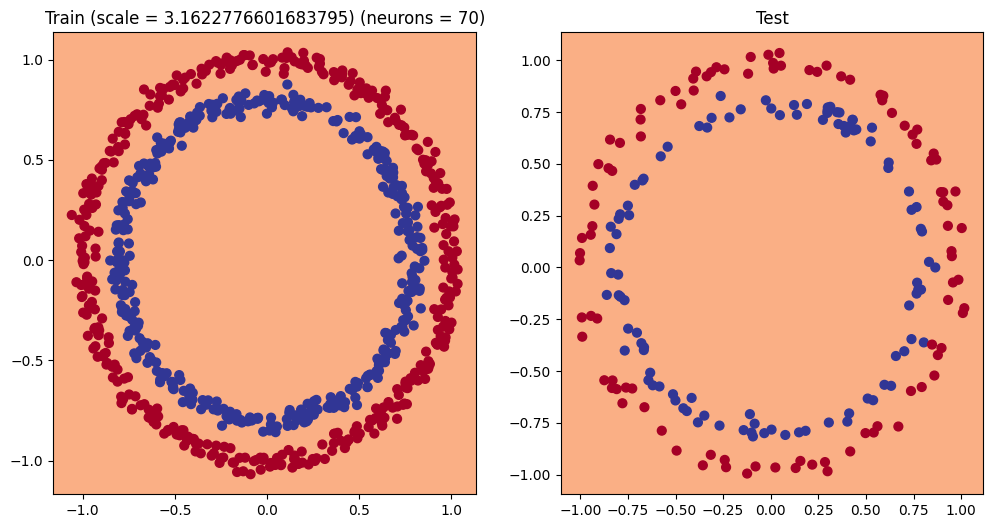

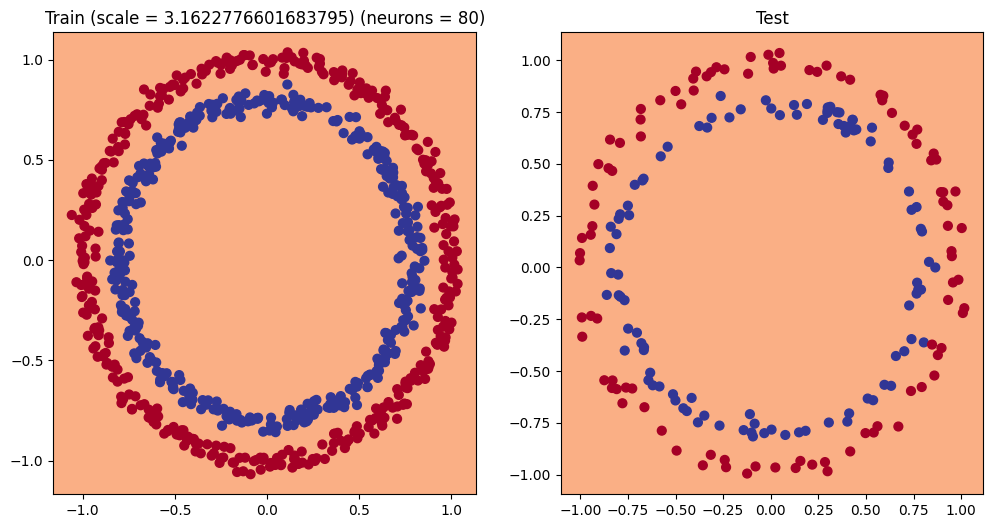

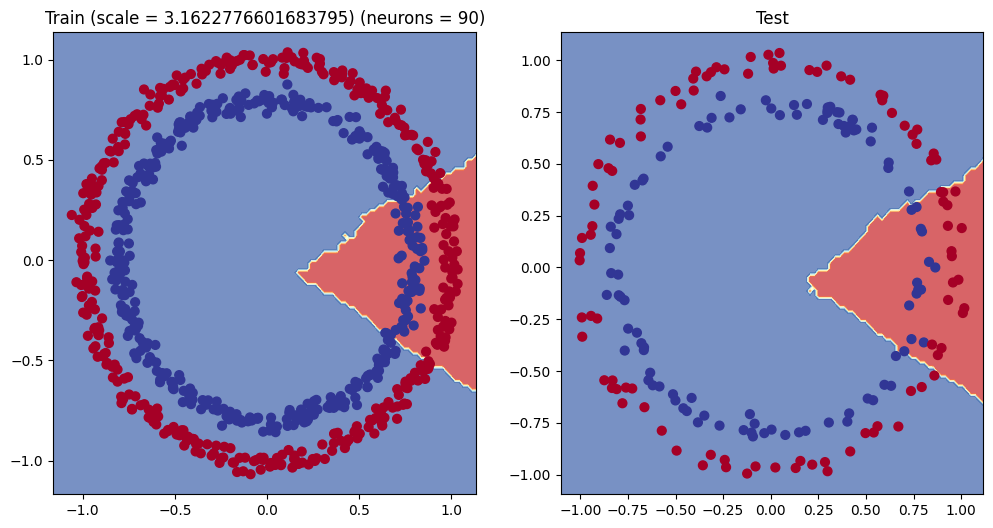

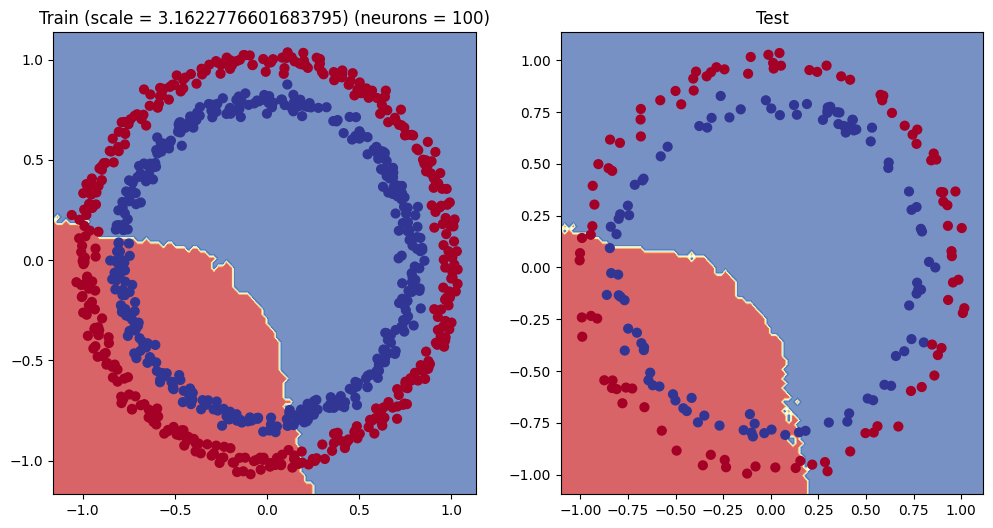

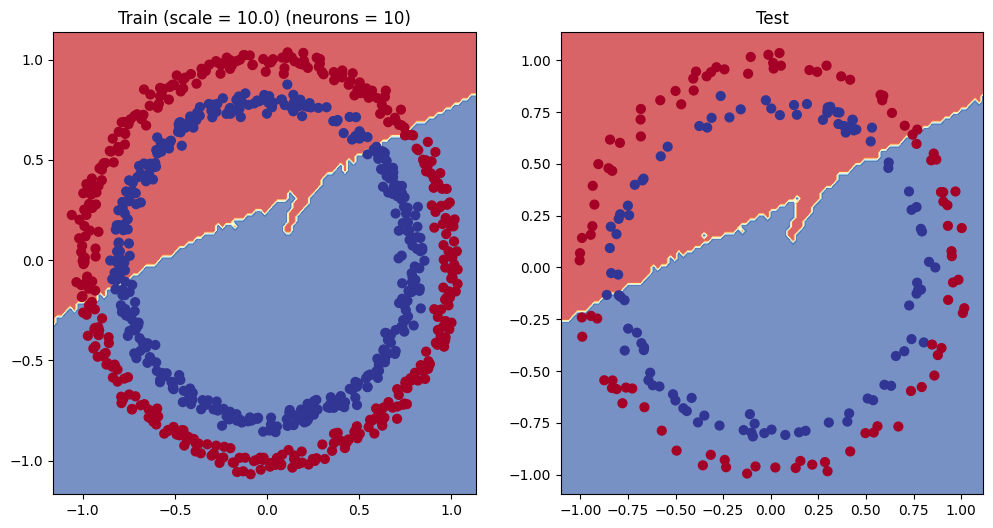

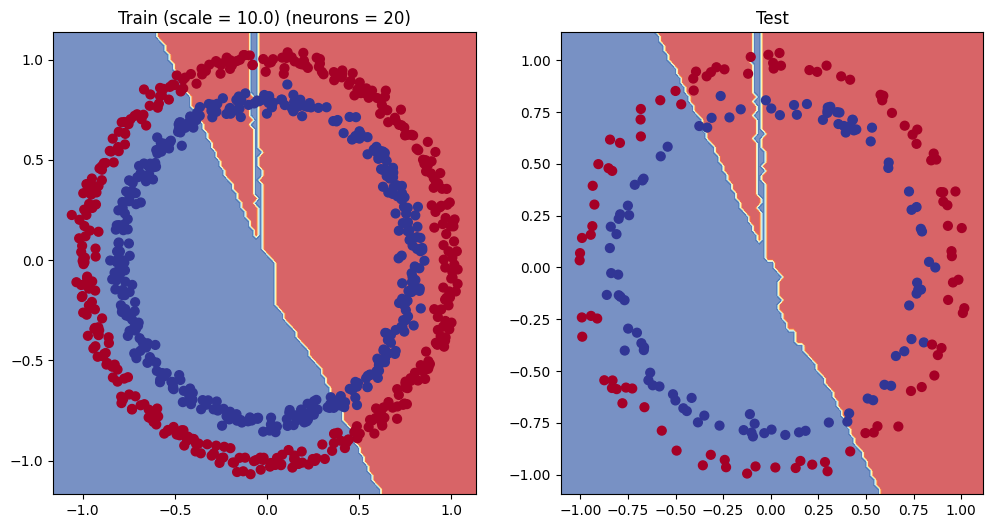

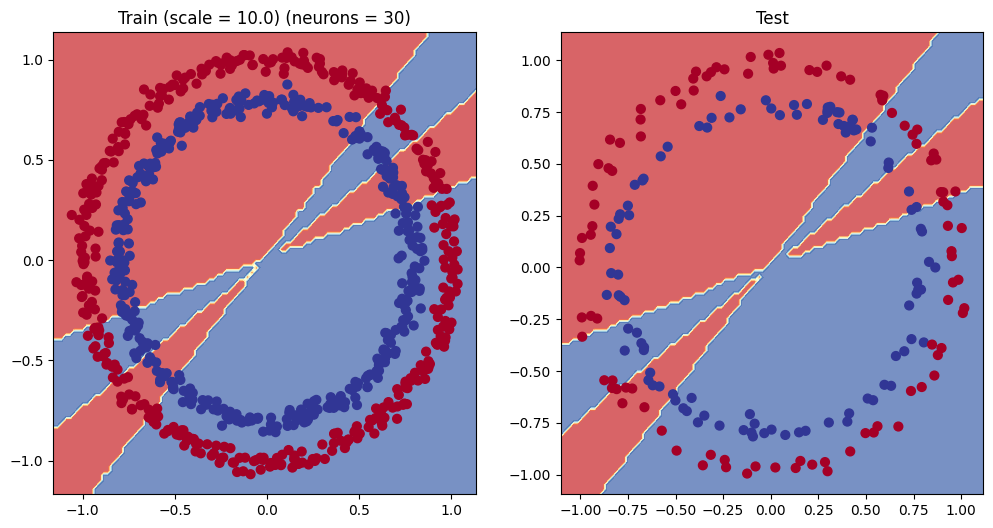

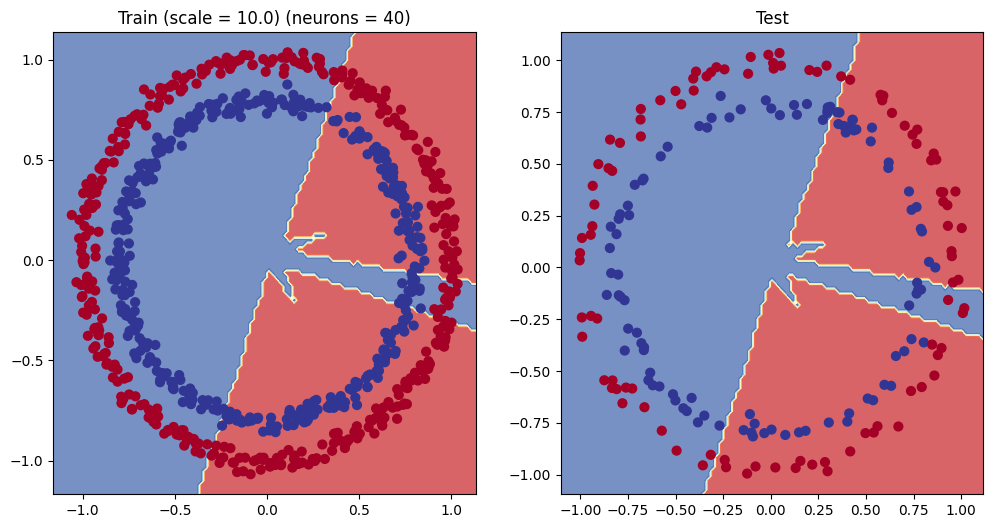

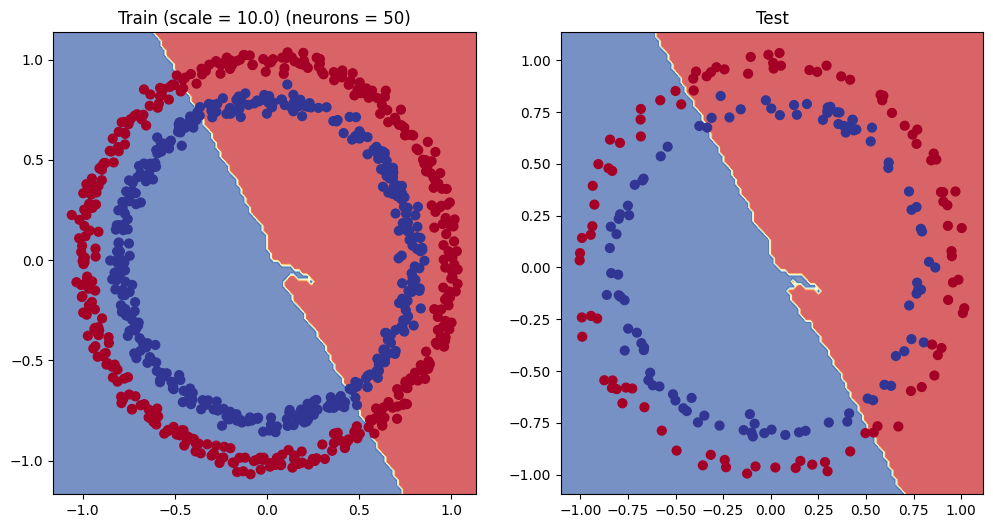

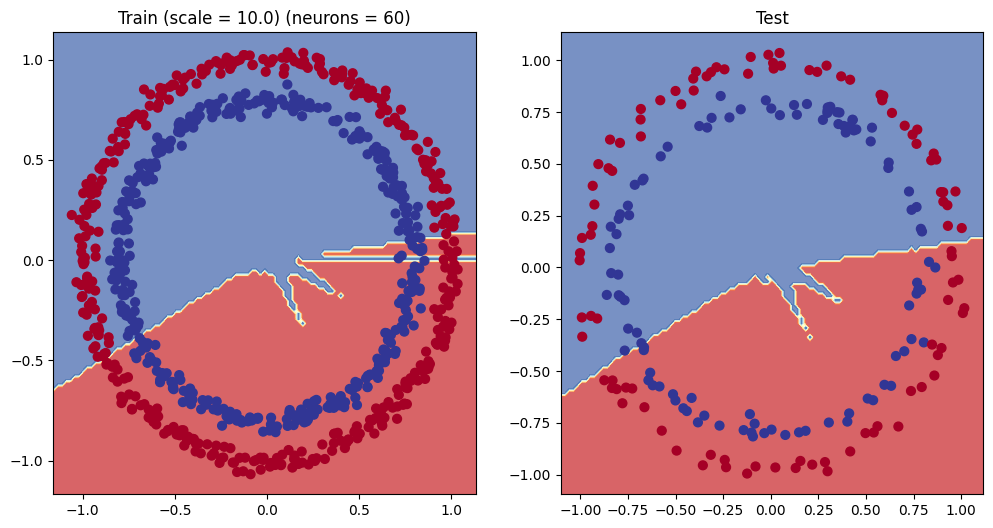

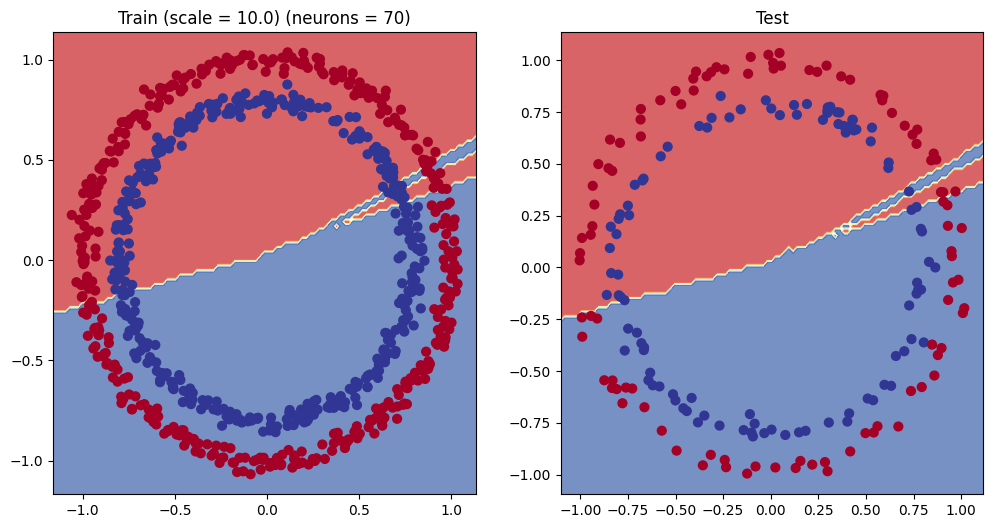

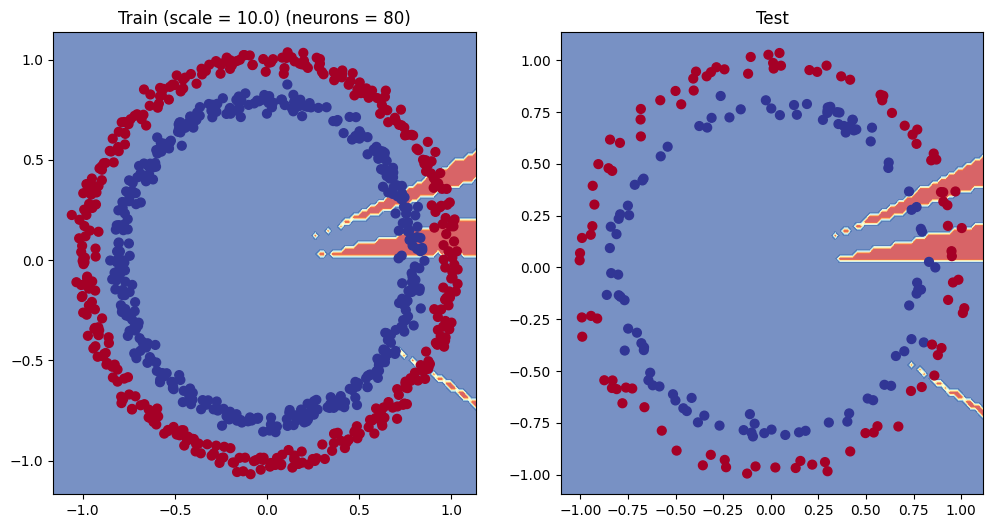

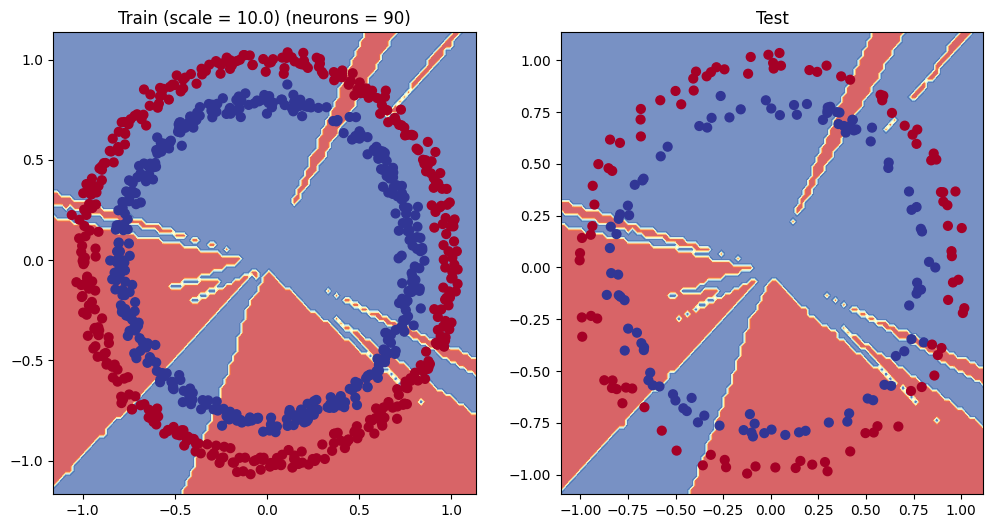

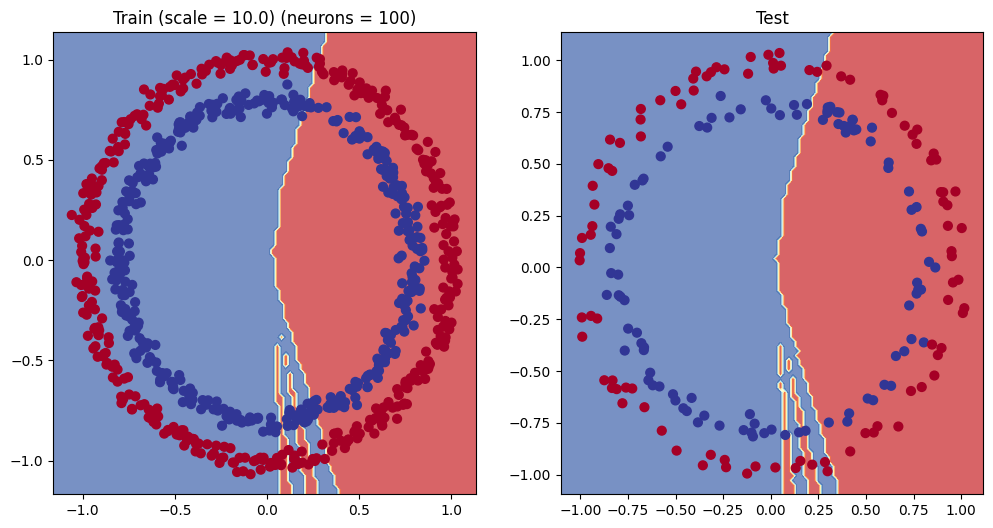

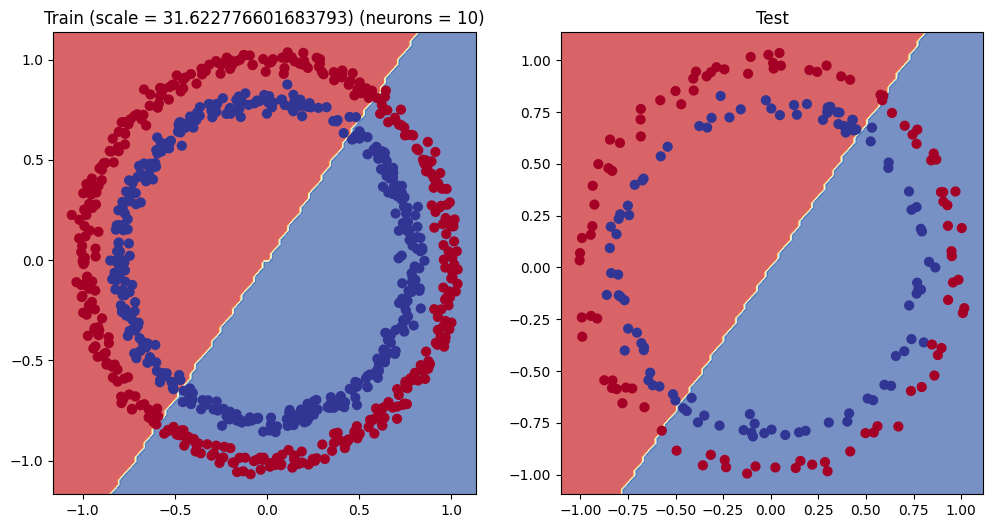

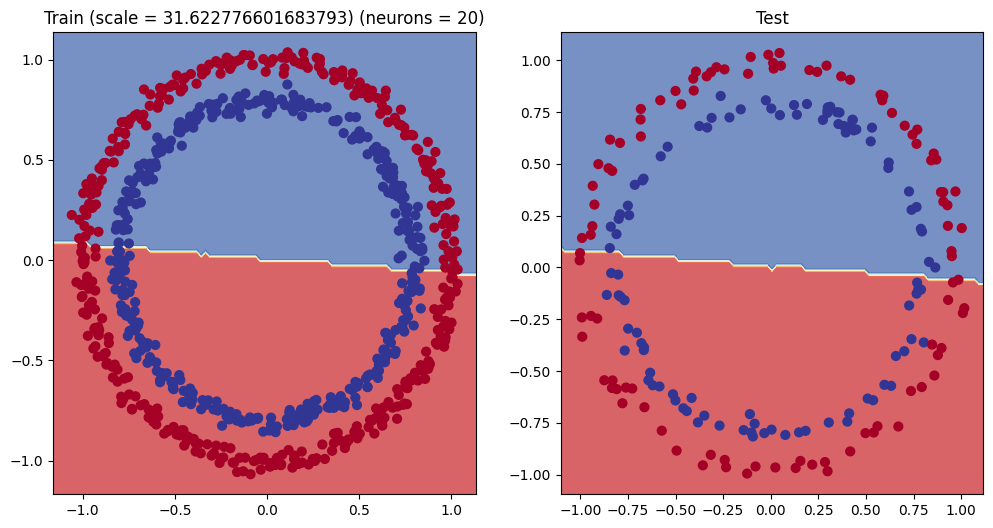

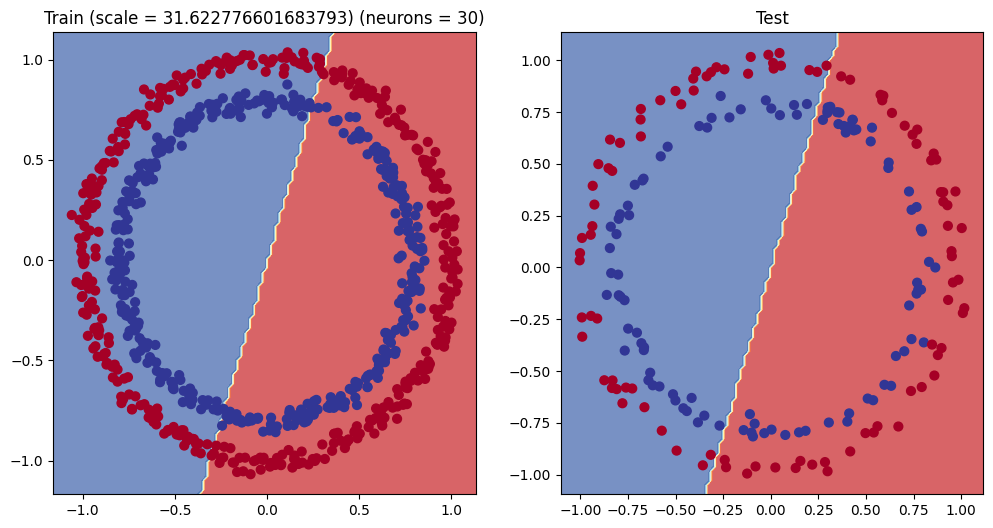

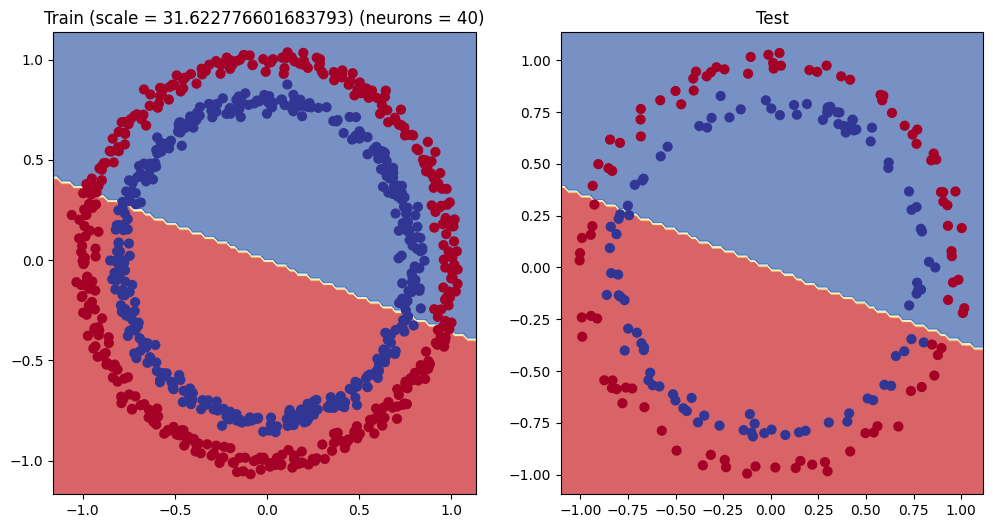

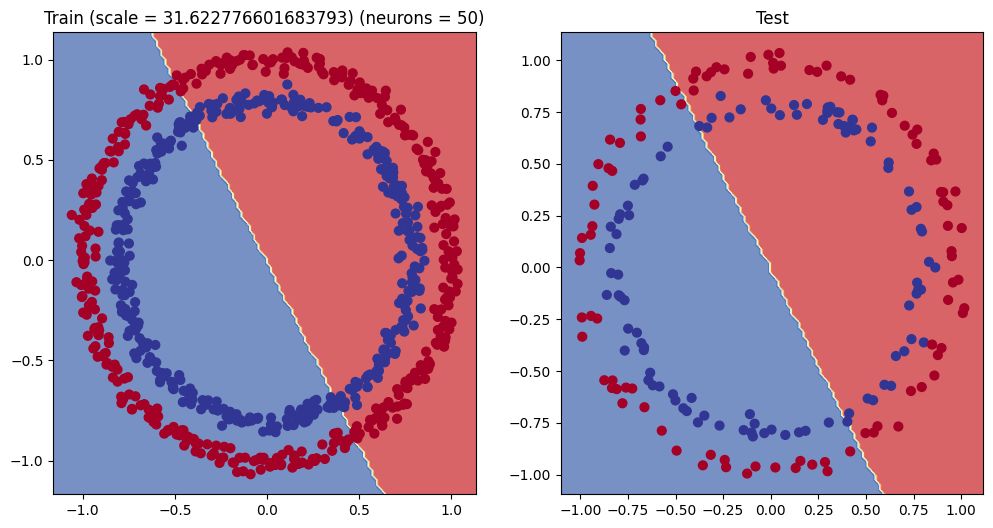

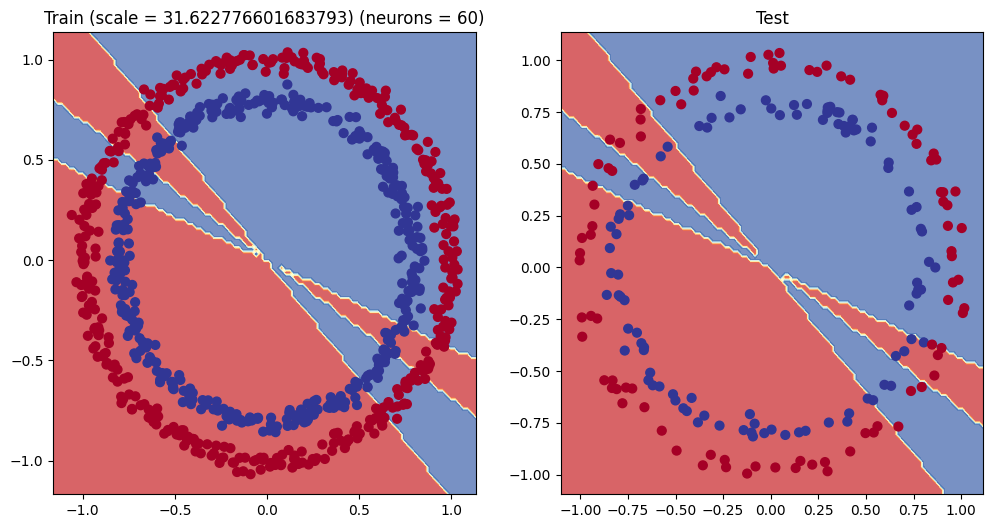

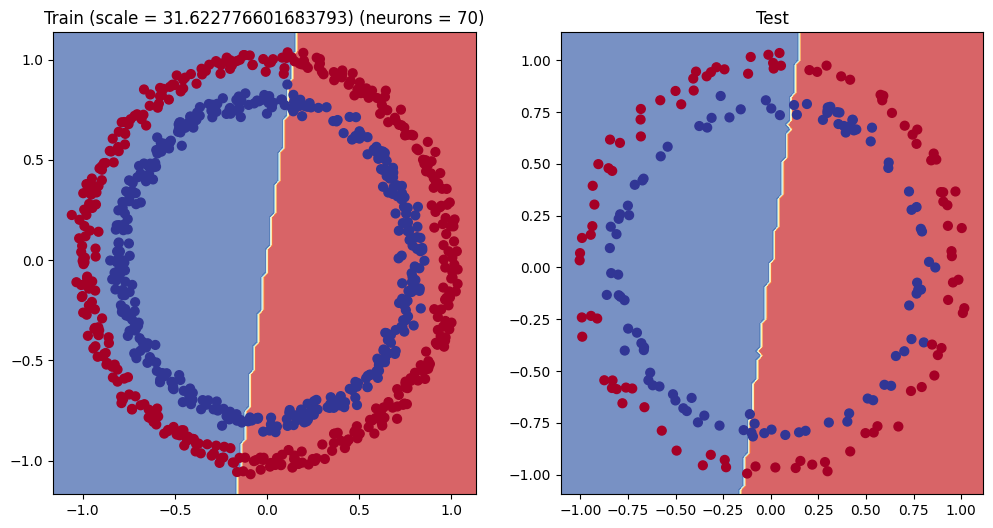

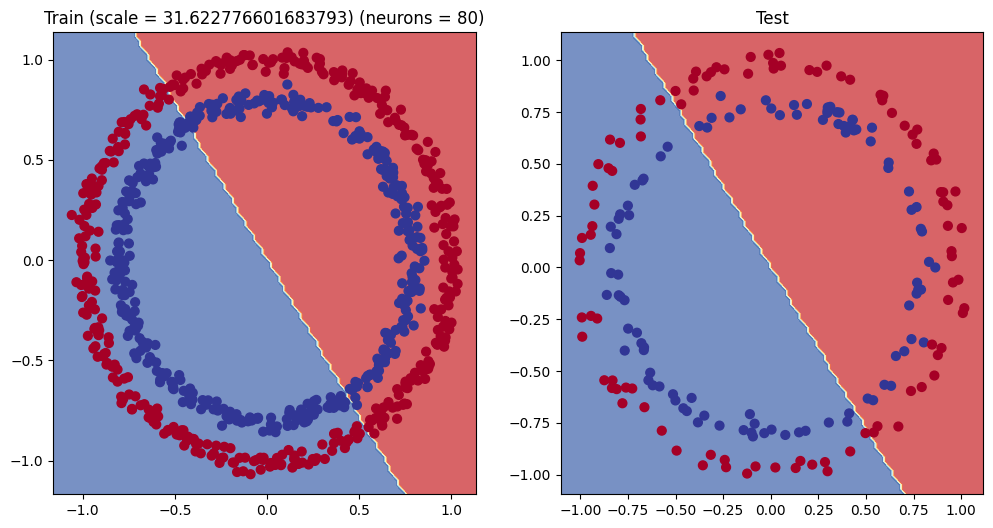

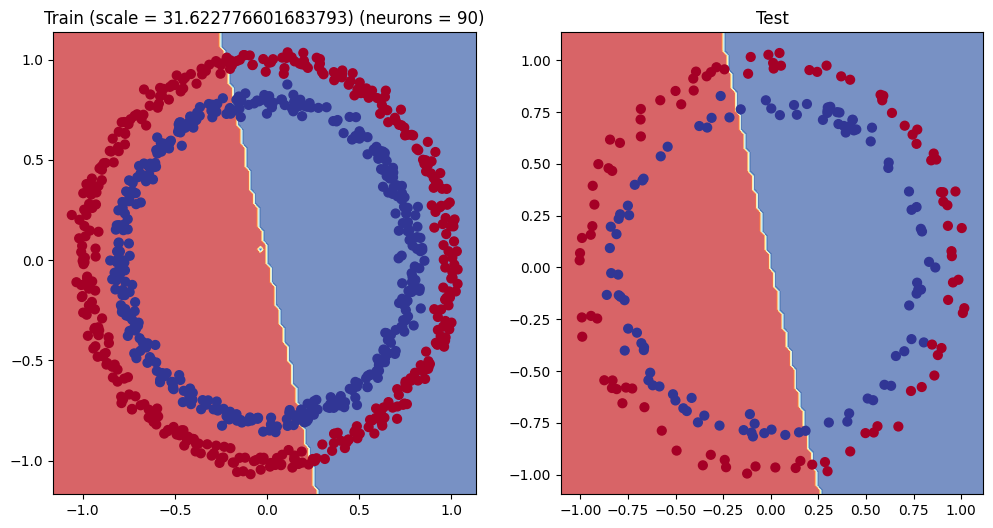

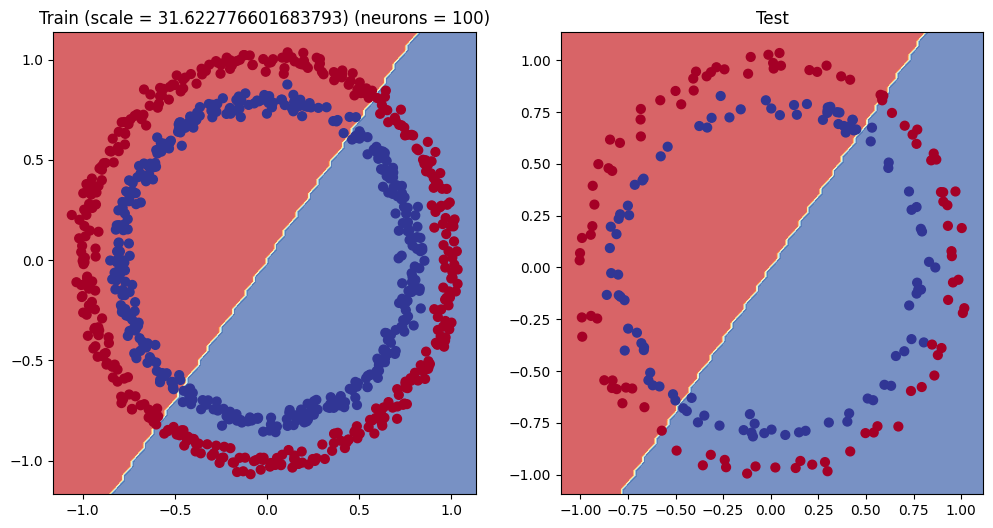

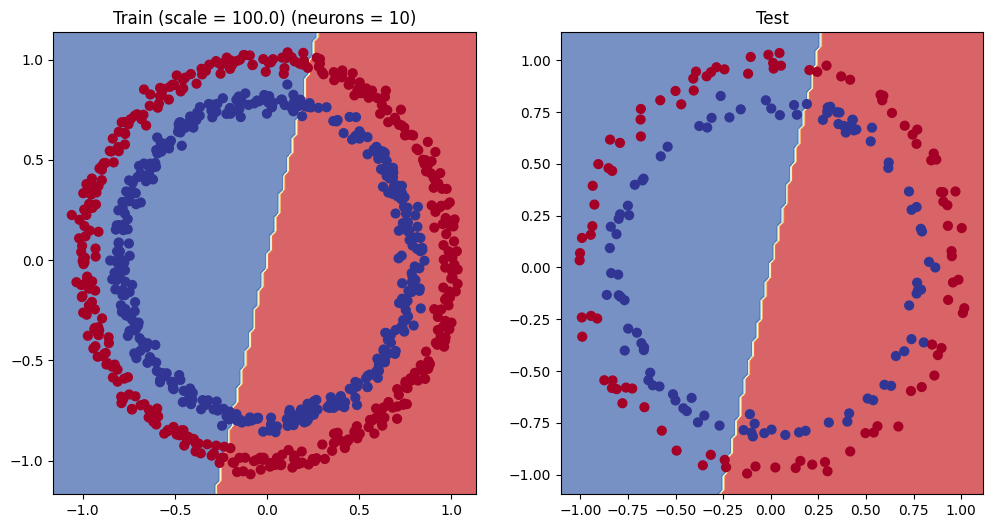

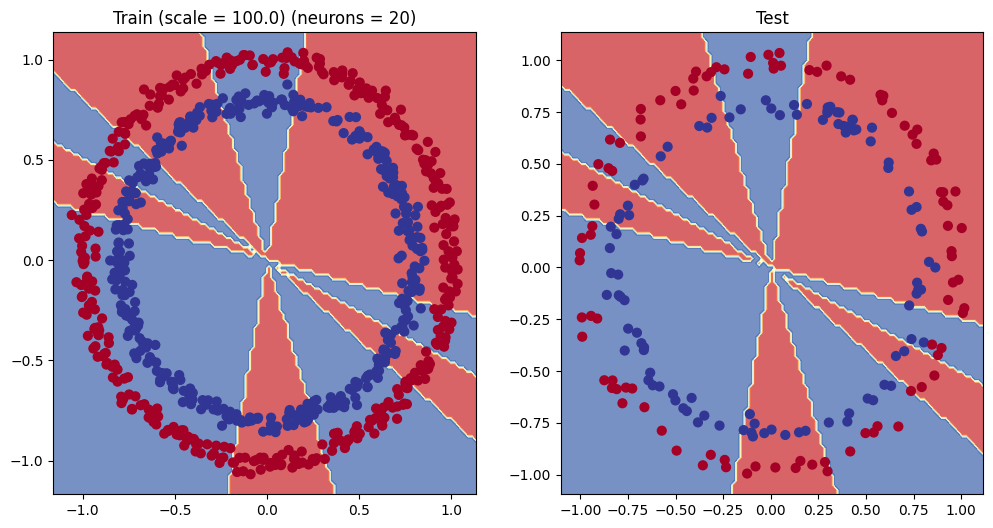

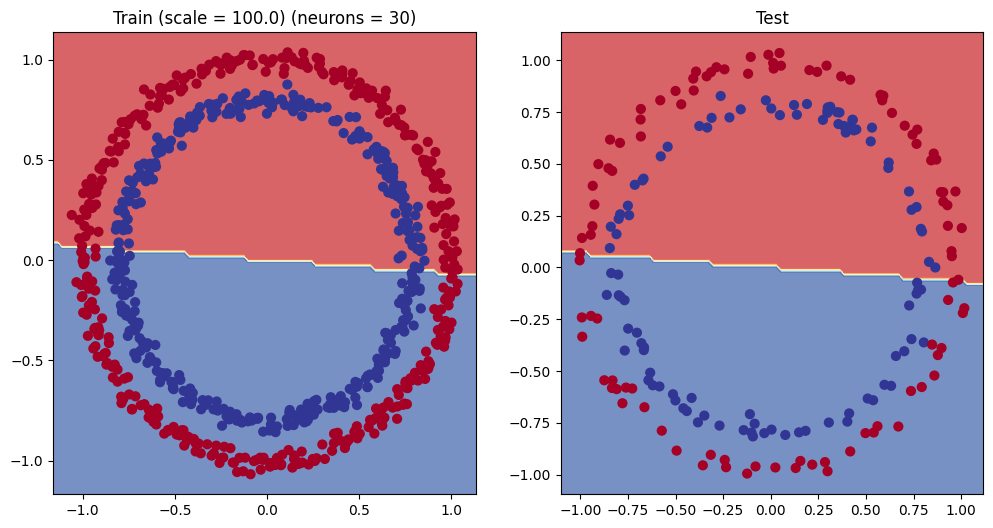

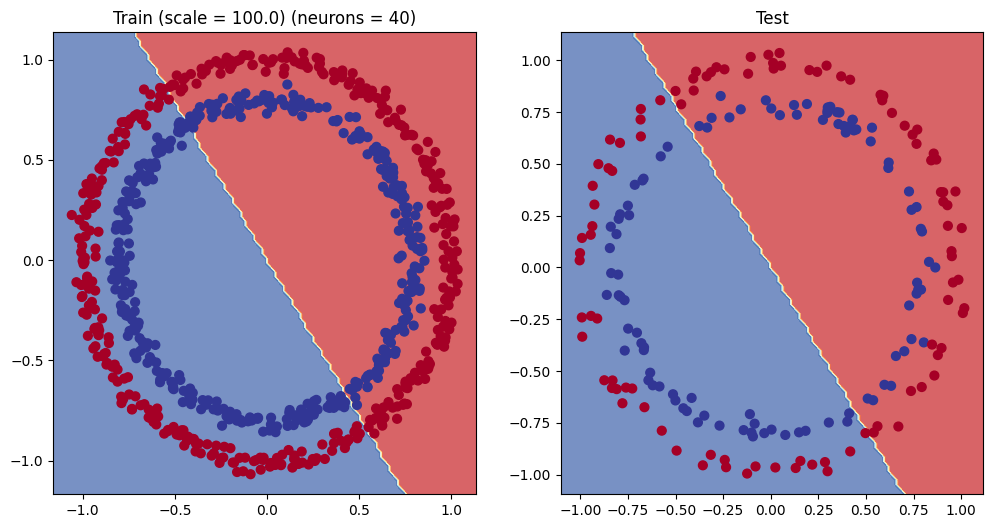

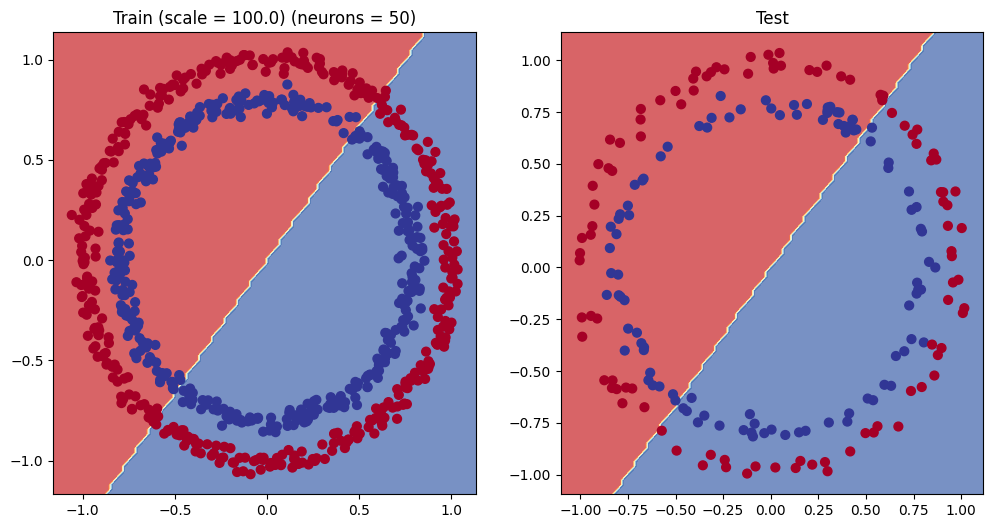

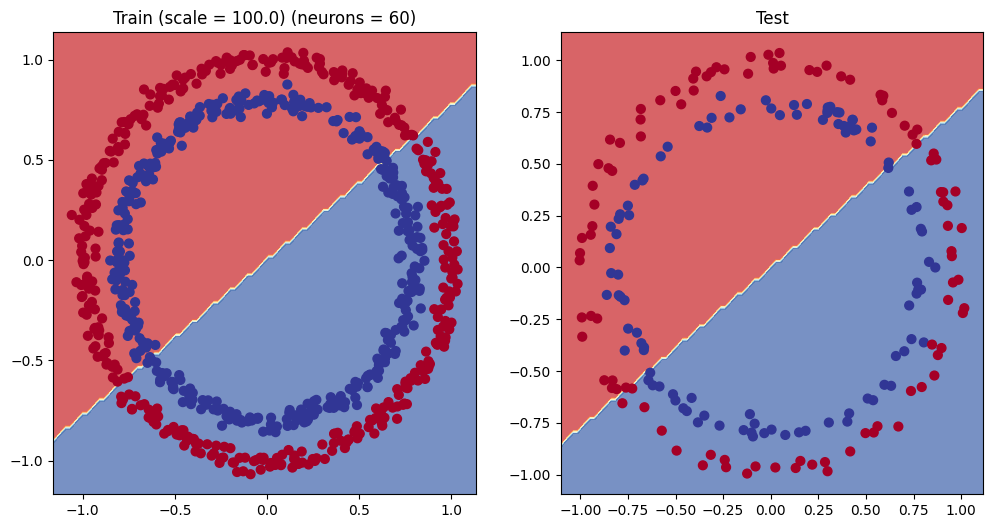

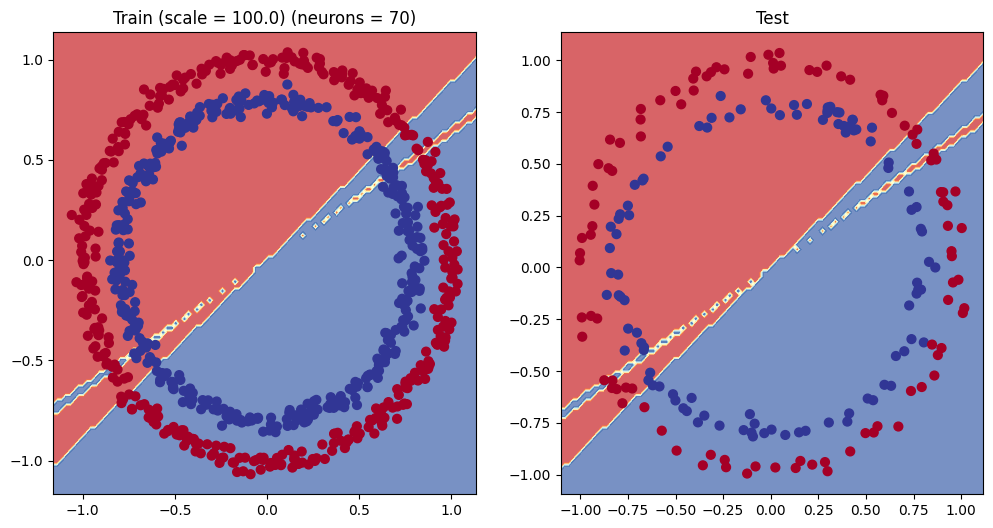

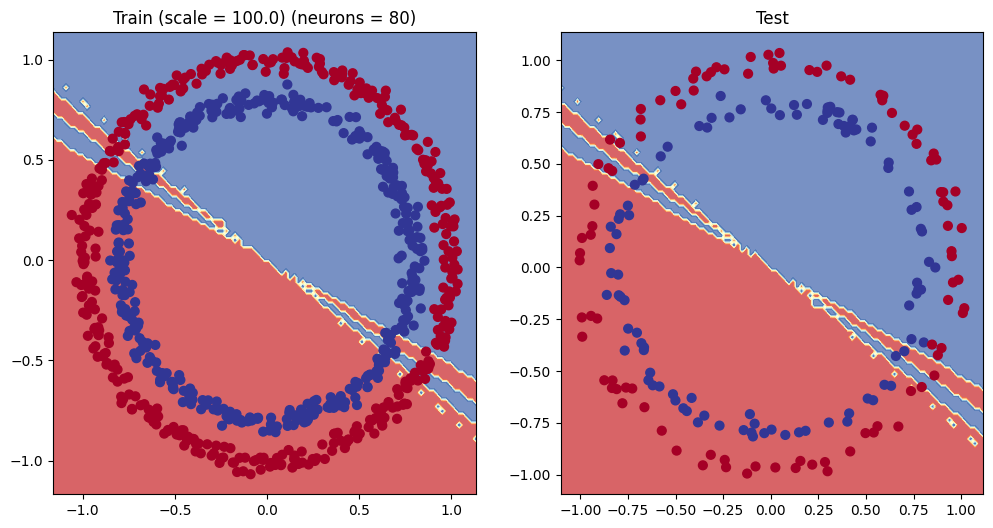

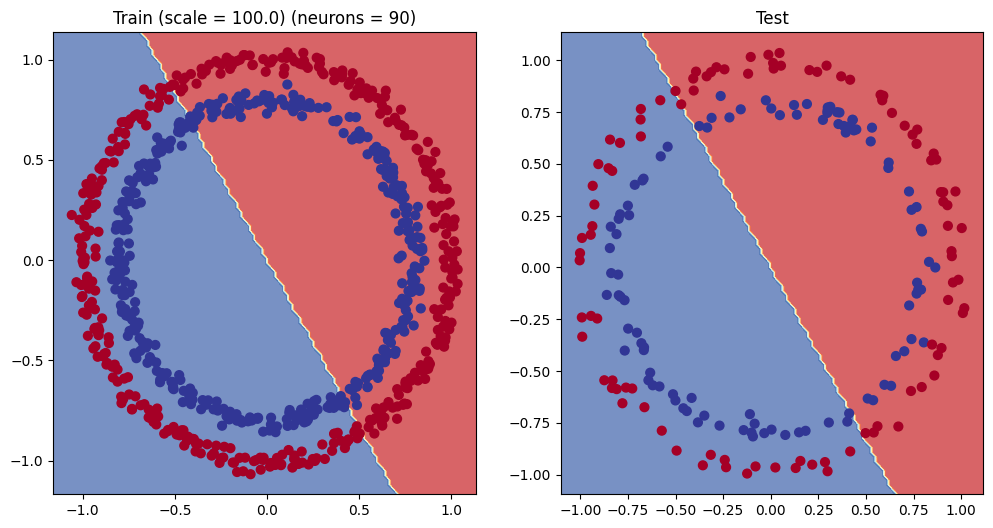

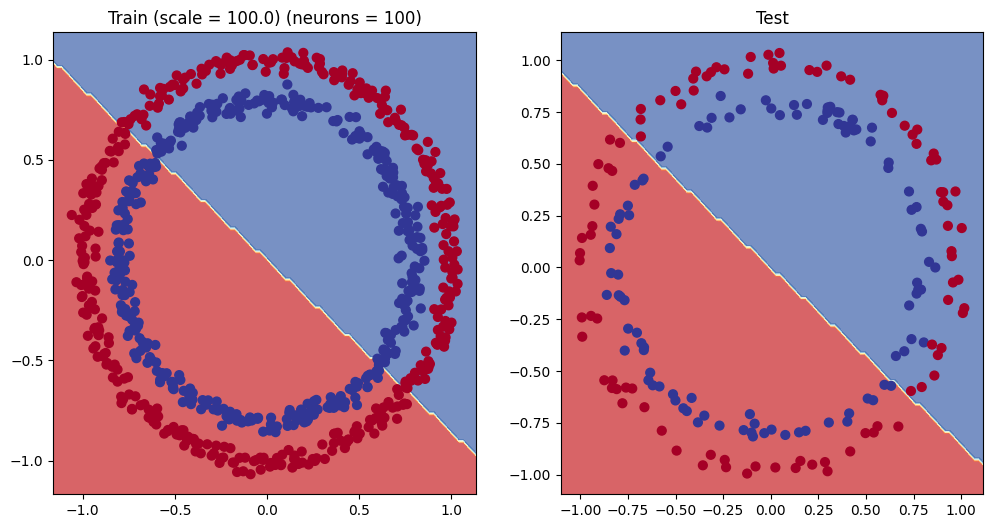

In [1833]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

noises = []
accuracy = []
finalaccuracy = []
finalnoise = []

for i in range(5):
    for j in range(10):
        neurons = (j+1)*10
        scale= 10**(i/2)
        print(scale)
        model_0 = makeModel(scale, neurons)
        print(model_0)
        # loss_fn = nn.MSELoss() # BCEWithLogitsLoss = sigmoid built-in
        loss_fn = nn.CrossEntropyLoss()


    # Create an optimizer
        optimizer = torch.optim.SGD(params=model_0.parameters(), 
                                lr=0.01)
        optimizer.zero_grad()

        
        for epoch in range(epochs):
            ### Training
            model_0.train()

            # 1. Forward pass (model outputs raw logits)
            y_logits = model_0(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device 
            y_pred = torch.round(y_logits) # turn logits -> pred probs -> pred labls

            # 2. Calculate loss/accuracy
            # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
            #                y_train) 
            loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits
                        y_train) 
            acc = accuracy_fn(y_true=y_train, 
                            y_pred=y_pred) 

            # 3. Optimizer zero grad
            optimizer.zero_grad()

            # 4. Loss backwards
            loss.backward()

            # 5. Optimizer step
            optimizer.step()

            ### Testing
            model_0.eval()
            with torch.inference_mode():
                # 1. Forward pass
                test_logits = model_0(X_test).squeeze() 
                test_pred = torch.round(test_logits)
                # 2. Caculate loss/accuracy
                test_loss = loss_fn(test_logits,
                                    y_test)
                test_acc = accuracy_fn(y_true=y_test,
                                    y_pred=test_pred)

            # Print out what's happening every 10 epochs
            if epoch % 100 == 0:
                print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")
        plot(scale, neurons)
    # noises.append(-x)
    # accuracy.append(acc)
    # finalaccuracy.append(acc)
    # finalnoise.append(-x)